In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-29'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664882710,49829,29841,sell,0x287a3187a2b5584f8f8798ec36f45cc2336d7b74,NaN,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,395.0,453.0,100.0,553.0
1,1664882656,49828,40251,sell,0x4295e2baeb32a09c039f9473f9bd5d7074d38649,NaN,0.84,sneakers,common,sprinter,...,0.62,0.62,0.62,93.0,138.0,252.0,394.0,452.0,100.0,552.0
2,1664882641,49827,21513,sell,0xea16bf173dd03fc75961cc9b31b3ab1734528c60,NaN,0.77,sneakers,common,hiker,...,0.65,0.62,0.62,44.0,53.0,141.0,393.0,451.0,100.0,551.0
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
4,1664882626,49826,35908,sell,0x550ac8e10d959caad354529c4a2f9f67d2471968,NaN,0.84,sneakers,common,sprinter,...,0.62,0.62,0.62,92.0,137.0,251.0,393.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71918,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71919,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71920,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71921,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71923 entries, 0 to 71922
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  43892 non-null  float64
 1   time_ownership             43892 non-null  float64
 2   wallet_box_mint            43892 non-null  float64
 3   wallet_sneaker_mint        43892 non-null  float64
 4   time_level_up              46377 non-null  float64
 5   time_level_up_for_mint     50215 non-null  float64
 6   base_mint_price_amt        50215 non-null  float64
 7   base_mint_price_azy        50215 non-null  float64
 8   base_mint_price_bnb        40192 non-null  float64
dtypes: float64(9)
memory usage: 4.9 MB


In [12]:
data.genesis

0         True
1        False
2         True
3         True
4        False
         ...  
71918     True
71919    False
71920    False
71921    False
71922     True
Name: genesis, Length: 71923, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
16,1664882082,49816,48699,buy,0xf33443dd0bd01dbfeed406cd37148941e76496fe,0xe08ce97b21d4d92871c00315fe9a984e879d7cbe,0.61,sneakers,common,sprinter,...,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
17,1664882046,49818,65273,buy,0xd3b1cc01a0ce14e709bac7c28b0bfeddff163bcf,0x0e771bf8425a5633972c4550ee916b870eb7f728,0.90,sneakers,common,ranger,...,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
30,1664881458,49811,57020,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x52aede929fea19342d6e63d600e88064d3b84e99,0.63,sneakers,common,hiker,...,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71860,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71883,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71897,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71902,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
cancel_count_24H more then expected. get: 1348 | expected: 1000


In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12967 non-null  int64  
 1   mrk_id                                           12967 non-null  int64  
 2   token_id                                         12967 non-null  int64  
 3   event                                            12967 non-null  object 
 4   wallet_from                                      12933 non-null  object 
 5   wallet_to                                        12967 non-null  object 
 6   price                                            12967 non-null  float64
 7   item_type                                        12967 non-null  object 
 8   rarity                                           12967 non-null  object 
 9   sneaker_type                

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  12967 non-null  float64
 1   time_ownership             12967 non-null  float64
 2   wallet_box_mint            12967 non-null  float64
 3   wallet_sneaker_mint        12967 non-null  float64
 4   time_level_up              12967 non-null  float64
 5   time_level_up_for_mint     12967 non-null  float64
 6   base_mint_price_amt        12967 non-null  float64
 7   base_mint_price_azy        12967 non-null  float64
 8   base_mint_price_bnb        10577 non-null  float64
dtypes: float64(9)
memory usage: 1013.0 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
3,1.657811e+09,636768.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.442615
15,1.658155e+09,53456.0,14.0,24.0,11400.0,1800.0,1200.0,800.0,1.763929
16,1.663132e+09,270.0,4.0,8.0,900.0,1800.0,300.0,200.0,0.441212
17,1.664770e+09,756.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.441212
30,1.659549e+09,1002238.0,13.0,13.0,900.0,1800.0,300.0,200.0,0.440034
...,...,...,...,...,...,...,...,...,...
71860,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
71883,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
71897,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
71902,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12967 non-null  int64  
 1   mrk_id                                           12967 non-null  int64  
 2   token_id                                         12967 non-null  int64  
 3   event                                            12967 non-null  object 
 4   wallet_from                                      12933 non-null  object 
 5   wallet_to                                        12967 non-null  object 
 6   price                                            12967 non-null  float64
 7   item_type                                        12967 non-null  object 
 8   rarity                                           12967 non-null  object 
 9   sneaker_type                

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
16,1664882082,49816,48699,buy,0xf33443dd0bd01dbfeed406cd37148941e76496fe,0xe08ce97b21d4d92871c00315fe9a984e879d7cbe,0.61,sneakers,common,sprinter,...,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
17,1664882046,49818,65273,buy,0xd3b1cc01a0ce14e709bac7c28b0bfeddff163bcf,0x0e771bf8425a5633972c4550ee916b870eb7f728,0.90,sneakers,common,ranger,...,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
30,1664881458,49811,57020,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x52aede929fea19342d6e63d600e88064d3b84e99,0.63,sneakers,common,hiker,...,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71860,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71883,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71897,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71902,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date
71427,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:15:49
71376,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:55:43
71173,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 13:12:37
70978,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 15:32:25
70247,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,1664868118,49500,62008,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x17958d240dad88c2706578d22fa4474fe982b2c9,0.75,sneakers,common,coacher,...,0.6,0.6,14.0,132.0,233.0,368.0,426.0,102.0,528.0,2022-10-04 07:21:58
223,1664870977,49699,53605,buy,0xc12d41b205935dde2a86b485368509885b5df307,0x991228738470f28009632dc21efc6abc3f8be169,0.61,sneakers,common,ranger,...,0.6,0.6,94.0,141.0,246.0,382.0,441.0,105.0,546.0,2022-10-04 08:09:37
186,1664873014,49682,38979,buy,0xcad73ca0e96049e437e3f74dd8213fd52596f77d,0x96fe731482847a93305044cb167f7eb988dc5a11,0.60,sneakers,common,hiker,...,0.6,0.6,94.0,142.0,248.0,385.0,448.0,103.0,551.0,2022-10-04 08:43:34
184,1664873059,49496,42236,buy,0xa3378795e34786ed8ed02bd5b8acbca5875687a4,0x27608f0a41d3bfea92c5b8f59ea8198dd4d00cb6,0.73,sneakers,common,ranger,...,0.6,0.6,14.0,139.0,245.0,382.0,445.0,103.0,548.0,2022-10-04 08:44:19


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11.0

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date,sum_activity_24H,sells_activity_24H
56763,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
52525,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

3436

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,NaN,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,1664817561,49196,64926,buy,0xc937de0f393752b7c1108947ac45b34bed5b1956,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,2.0,sneakers,uncommon,hiker,...,418.0,102.0,520.0,2022-10-03 17:19:21,1354,2.13354,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,2.35,2022-10-04 07:21:40,0.2325
1555,1664821316,49268,29804,buy,0x6b5bc4675e0bf4f4ccc13ca3c7d4ed8fe579ec32,0xdcfa6b56a12f15ddfe529e094c004dfbd0d4809a,0.65,sneakers,common,coacher,...,423.0,105.0,528.0,2022-10-03 18:21:56,1371,2.135802,0xdcfa6b56a12f15ddfe529e094c004dfbd0d4809a,0.85,2022-10-03 20:08:36,0.1575
1556,1664834329,49476,62008,buy,0x8ce811213d833bdc2f33ad33d219a54e4bc1699d,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.6,sneakers,common,coacher,...,440.0,96.0,536.0,2022-10-03 21:58:49,1559,2.289474,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.75,2022-10-04 07:21:58,0.1125
1557,1664861962,49567,64891,buy,0xc937de0f393752b7c1108947ac45b34bed5b1956,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.67,sneakers,common,ranger,...,420.0,101.0,521.0,2022-10-04 05:39:22,1617,2.34957,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.78,2022-10-04 06:47:27,0.071


In [37]:
final_df.profit.median()

0.0020000000000000018

In [38]:
final_df.profit.sum()

-54.71117499999995

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

494

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

189

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

18

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0xfc2eb423826124d624db5f7d1a43f8f826750efe      -7.136
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
                                                ...   
0x6666660f03b2b63bdc2cf7f7ee2821645106c798        3.67
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba        4.82
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7      11.709
Name: profit, Length: 494, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

184

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

18

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

618

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0x6666660f03b2b63bdc2cf7f7ee2821645106c798      3.67
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.82
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7    11.709
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

318

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

1        1
2        2
28      11
54      51
57      57
        ..
1500     7
1537    17
1556     9
1557     1
1558     1
Name: sell_time, Length: 318, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

5.577

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.114,0.279
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.050,0.288
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,3.539,5.178
54,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,-0.039,0.070
57,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,-0.032,0.090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,1664617134,47427,47294,buy,NaN,0x6666660f03b2b63bdc2cf7f7ee2821645106c798,0.48,sneakers,common,hiker,...,1152,2.747475,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.57,2022-10-01 16:43:05,0.0615,7,0.0615,0.093,0.347
1537,1664742275,48584,23418,buy,NaN,0x6666660f03b2b63bdc2cf7f7ee2821645106c798,0.50,sneakers,common,coacher,...,1331,2.252459,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,1.45,2022-10-03 13:29:13,0.8775,17,0.8775,0.363,0.640
1556,1664834329,49476,62008,buy,0x8ce811213d833bdc2f33ad33d219a54e4bc1699d,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.60,sneakers,common,coacher,...,1559,2.289474,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.75,2022-10-04 07:21:58,0.1125,9,0.1125,0.078,0.170
1557,1664861962,49567,64891,buy,0xc937de0f393752b7c1108947ac45b34bed5b1956,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.67,sneakers,common,ranger,...,1617,2.349570,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.78,2022-10-04 06:47:27,0.0710,1,0.0710,0.008,0.156


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

239

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
476,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
477,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
480,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
488,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
489,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,272.388395,0.060855,0.435786,1663344280.0,782356.0,3.0,3.0,900,1800.0,300.0,200.0,0.524644,2022-09-27 22:06:49
1426,272.818367,0.060615,0.430875,0.0,1664323783.0,0.0,0.0,0,1800.0,300.0,200.0,0.518241,2022-09-28 00:09:43
1428,270.444632,0.060139,0.431125,0.0,1664329564.0,0.0,0.0,0,1800.0,300.0,200.0,0.522715,2022-09-28 01:46:04
1429,270.028323,0.059049,0.431080,0.0,1664336085.0,0.0,0.0,900,1800.0,300.0,200.0,0.522663,2022-09-28 03:34:45


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 476 to 1450
Data columns (total 92 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        239 non-null    int64         
 1   mrk_id                                           239 non-null    int64         
 2   token_id                                         239 non-null    int64         
 3   event                                            239 non-null    object        
 4   wallet_from                                      224 non-null    object        
 5   wallet_to                                        239 non-null    object        
 6   price                                            239 non-null    float64       
 7   item_type                                        239 non-null    category      
 8   rarity                               

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.62it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.90it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.99it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  2.99it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  2.99it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  3.01it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:03,  3.01it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.190000e-01,3.738000e-01
MAE,1.050000e-01,3.590000e-02
MSE,4.700000e-02,8.200000e-02
RMSE,1.760000e-01,1.268000e-01
MAPE,1.713326e+12,5.229032e+12


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.190000e-01,3.738000e-01
MAE,1.050000e-01,3.590000e-02
MSE,4.700000e-02,8.200000e-02
RMSE,1.760000e-01,1.268000e-01
MAPE,1.713326e+12,5.229032e+12


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.285,
 'MAE': 0.105,
 'MSE': 0.047,
 'RMSE': 0.216,
 'MAPE': 1695916177672.027}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


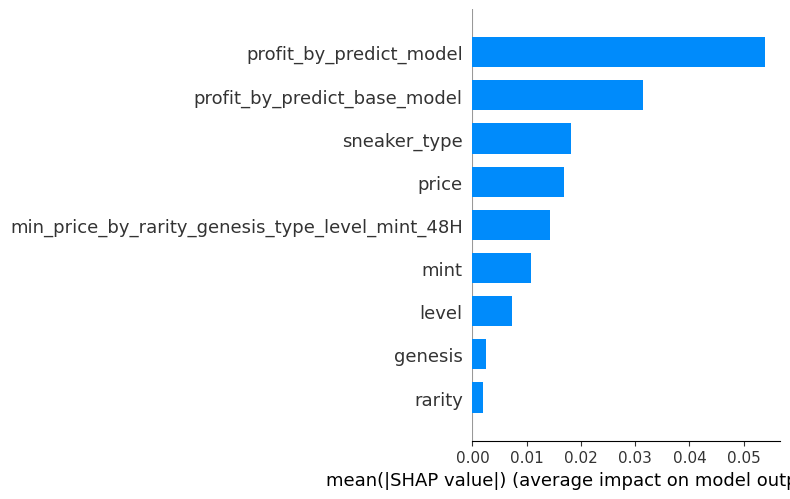

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1268169	total: 616us	remaining: 616ms
1:	learn: 0.1258111	total: 1.59ms	remaining: 793ms
2:	learn: 0.1247205	total: 2.12ms	remaining: 706ms
3:	learn: 0.1238001	total: 2.69ms	remaining: 669ms
4:	learn: 0.1227170	total: 3.28ms	remaining: 653ms
5:	learn: 0.1219560	total: 3.73ms	remaining: 619ms
6:	learn: 0.1212060	total: 4.26ms	remaining: 604ms
7:	learn: 0.1206272	total: 4.74ms	remaining: 587ms
8:	learn: 0.1199177	total: 5.24ms	remaining: 577ms
9:	learn: 0.1189793	total: 5.73ms	remaining: 567ms
10:	learn: 0.1181571	total: 6.16ms	remaining: 554ms
11:	learn: 0.1177695	total: 6.63ms	remaining: 546ms
12:	learn: 0.1171238	total: 7.17ms	remaining: 545ms
13:	learn: 0.1167488	total: 7.69ms	remaining: 542ms
14:	learn: 0.1161980	total: 8.06ms	remaining: 529ms
15:	learn: 0.1157424	total: 8.38ms	remaining: 516ms
16:	learn: 0.1151179	total: 8.7ms	remaining: 503ms
17:	learn: 0.1147258	total: 9ms	remaining: 491ms
18:	learn: 0.1142683	total: 9.32ms	remaining: 481ms
19:	learn: 0.1138007	total:

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.839, 'MAE': 0.064, 'MSE': 0.009, 'RMSE': 0.094, 'MAPE': 0.661}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

2.4404999999999992

In [80]:
submission

,profit,pred
0,0.0215,0.118
1,0.1700,0.252
2,0.3200,0.379
3,0.4500,0.494
4,0.1015,0.074
5,0.0590,0.033
6,0.1255,0.089
7,0.0615,0.084
8,0.8775,0.598
9,0.1125,0.053


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

2.381499999999999

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.84, 'MAE': 0.064, 'MSE': 0.009, 'RMSE': 0.094, 'MAPE': 0.668}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.1275698	total: 611us	remaining: 611ms
1:	learn: 0.1263641	total: 1.11ms	remaining: 554ms
2:	learn: 0.1255407	total: 1.6ms	remaining: 532ms
3:	learn: 0.1249001	total: 1.98ms	remaining: 493ms
4:	learn: 0.1240742	total: 2.33ms	remaining: 464ms
5:	learn: 0.1229443	total: 2.71ms	remaining: 450ms
6:	learn: 0.1222806	total: 3.11ms	remaining: 441ms
7:	learn: 0.1212843	total: 3.52ms	remaining: 437ms
8:	learn: 0.1207113	total: 3.98ms	remaining: 439ms
9:	learn: 0.1201188	total: 4.41ms	remaining: 437ms
10:	learn: 0.1192524	total: 4.83ms	remaining: 434ms
11:	learn: 0.1186668	total: 5.29ms	remaining: 436ms
12:	learn: 0.1183615	total: 5.68ms	remaining: 432ms
13:	learn: 0.1179390	total: 6.09ms	remaining: 429ms
14:	learn: 0.1173510	total: 6.48ms	remaining: 425ms
15:	learn: 0.1166666	total: 6.86ms	remaining: 422ms
16:	learn: 0.1158607	total: 7.28ms	remaining: 421ms
17:	learn: 0.1152878	total: 7.68ms	remaining: 419ms
18:	learn: 0.1147296	total: 8.09ms	remaining: 418ms
19:	learn: 0.1142605	tot

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
246    0.0615
247    0.8775
248    0.1125
249    0.0710
250    0.0705
Name: target, Length: 251, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663019290,
 'mrk_id': 28412,
 'token_id': 47960,
 'event': 'buy',
 'wallet_from': '0xf5f1c1160efa7c9a2b9ad0724d2bc13592636244',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 1.0,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'hiker',
 'level': 0,
 'base_performance': 7.8,
 'base_fortune': 4.4,
 'base_joy': 9.0,
 'base_durability': 5.5,
 'performance': 7.8,
 'fortune': 4.4,
 'joy': 9.0,
 'durability': 5.5,
 'mint': 0,
 'parent1': 17278.0,
 'parent2': nan,
 'genesis': True,
 'parent1_sneaker_type': nan,
 'parent2_sneaker_type': nan,
 'price_bnb': 293.04159362,
 'price_azy': 0.0893487,
 'price_amt': 0.55756515,
 'wallet_from_buy_count': 0.0,
 'wallet_from_all_count': 1.0,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 227,
 'buy_count_24H': 308,
 'buy_count_48H': 540.0,
 'sell_count_12H': 453.0,
 'sell_count_24H': 669,
 'sell_count_48H': 1226.0,
 'cancel_count_12H': 304.0,
 'cancel_count_24H': 437,
 'ca

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                             common
sneaker_type                                        hiker
genesis                                              True
level                                                   0
mint                                                    0
min_price_by_rarity_genesis_type_level_mint_48H      0.75
price                                                 1.0
profit_by_predict_model                             0.013
profit_by_predict_base_model                       -0.069
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.086

In [90]:
data.iloc[i]['profit']

0.13050000000000006

iteritems is deprecated and will be removed in a future version. Use .items instead.


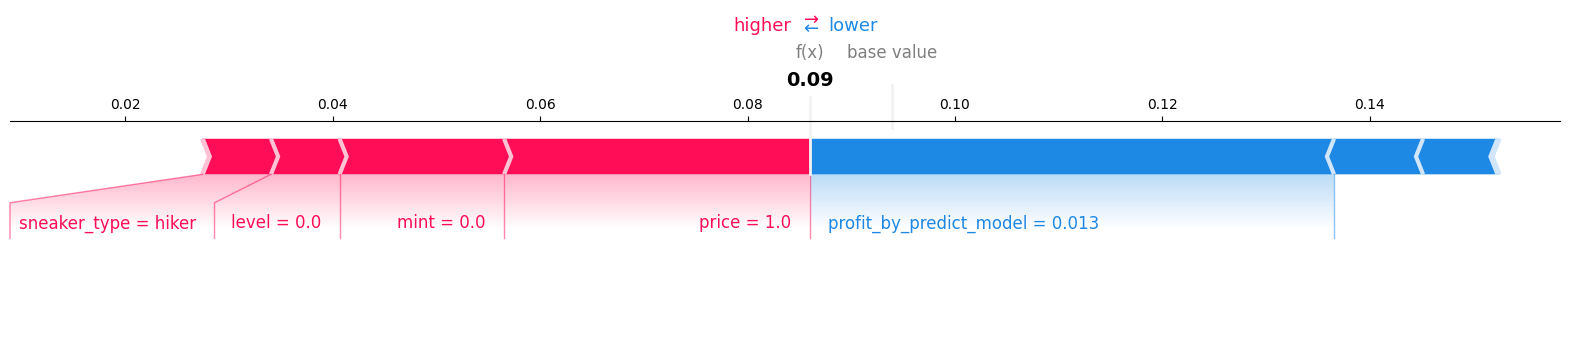

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)